## 残差网络（ResNet）

### 残差块

假设原始输入为$x$，希望学出的理想映射为$f(x)$。

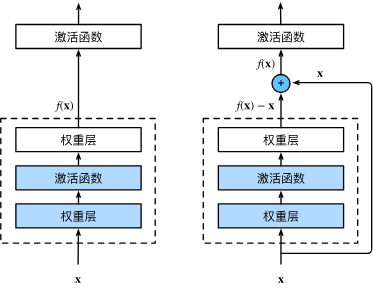

左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$。
残差映射在现实中往往更容易优化。

以恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。

实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。

右图是ResNet的基础架构--残差块（residual block）。
在残差块中，输入可通过跨层数据线路更快地向前传播。

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                              kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                              kernel_size = 3, padding = 1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                  kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
            
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

此代码生成两种类型的网络：

一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。

另一种是当use_1x1conv=True时，添加通过1×1卷积调整通道和分辨率。

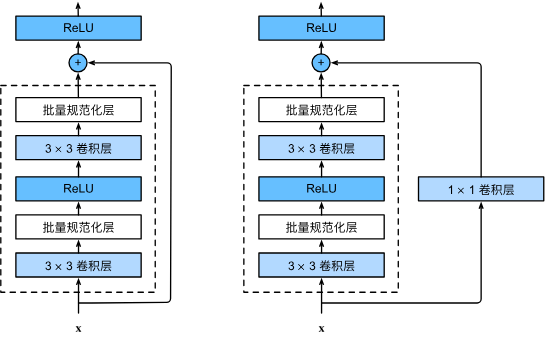

输入和输出形状一致的情况：

In [3]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

也可以在增加输出通道数的同时，减半输出的高和宽：

In [4]:
blk = Residual(3, 6, use_1x1conv = True, strides = 2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### ResNet模型

ResNet的前两层跟之前介绍的GoogLeNet中的一样：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

相比GoogleNet在后面接了4个由Inception块组成的模块，ResNet则使用4个残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                first_block = False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                               use_1x1conv = True, strides = 2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后在ResNet中加入全局平均汇聚层，以及全连接输出。

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的1×1卷积层），加上第一个7×7卷积层和最后一个全连接层，共有18层。因此，这种模型通常被称为ResNet-18.通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。

虽然ResNet的主体架构于GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致ResNet迅速被广泛利用。

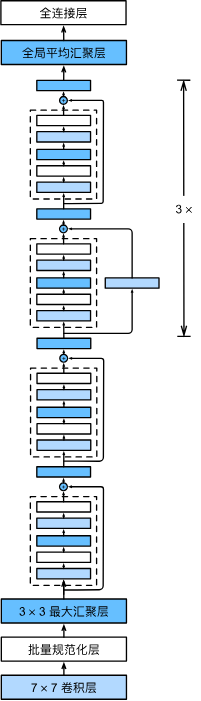

观察ResNet中不同模块的输入形状是如何变化的。

在之前的所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [9]:
X = torch.rand(size = (1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 训练

在Fashion-MNIST数据集上训练ResNet。

KeyboardInterrupt: 

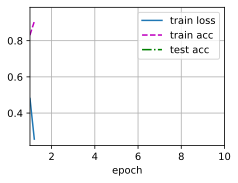

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())